## Analyze A/B Test Results



## Table of Contents

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these test results.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. For a user to "convert" means that they have decided to purchase the company's product.

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df_rows = df.shape[0]
df_rows

294478

In [4]:
df_nunique_user = df.user_id.nunique()
df_nunique_user

290584

In [5]:
df_nunique_user * 100 / df_rows

98.67766013080774

In [6]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
df_prop_converted = df.converted.mean()
df_prop_converted

0.11965919355605512

Identifying errors in webpage

In [8]:
#count instances comparing landing_page to group
print(df.groupby(['landing_page', 'group']).count())

#new_page and control OR old_page and treatment
df_num_no_match = 1928 + 1965
df_num_no_match

                        user_id  timestamp  converted
landing_page group                                   
new_page     control       1928       1928       1928
             treatment   145311     145311     145311
old_page     control     145274     145274     145274
             treatment     1965       1965       1965


3893

Check Missing values

In [9]:
df.isna().sum().max()

0

Drop errors in webpage

In [10]:
#drop rows where (group == treatment & landing_page == old_age) OR
#drop rows where (group == control & landing_page == new_page)
df_rows_drop = df.query('((group == "treatment" and landing_page == "old_page")) or ((group == "control" and landing_page == "new_page"))')

#store in new DataFrame
df2 = df.drop(df_rows_drop.index)
df2.shape[0]

290585

In [11]:
df2.groupby(['landing_page', 'group']).count()

,,user_id,timestamp,converted
landing_page,group,,,
new_page,treatment,145311,145311,145311
old_page,control,145274,145274,145274


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Check Number of unique users

In [13]:
df2_nunique_user = df2.user_id.nunique()
df2_nunique_user

290584

Check replicated users

In [14]:
repeated = df2.groupby( 'user_id' ).size().reset_index( name = 'count' )
repeated[ repeated[ 'count' ] > 1 ]

# Drop duplications

df2.drop_duplicates( subset= 'user_id', inplace = True )

In [15]:
# Probability of converting regardless the page they recieve
df2.converted.mean()

0.11959708724499628

Probability of converting in the `control` group

In [16]:
df2_control = df2[ df2[ 'group' ] == 'control' ]
df2_control.converted.mean()

0.1203863045004612

Probability of converting in the `treatment` group

In [17]:
df2_treatment = df2[df2['group'] == 'treatment']
df2_treatment.converted.mean()

0.11880806551510564

Probability that an individual received the new page

In [18]:
df2.groupby( 'landing_page' ).size() / df2.shape[0]

landing_page
new_page    0.500062
old_page    0.499938
dtype: float64

<a id='ab_test'></a>
### Part II - A/B Test


|**$p_{old}$** | **$p_{new}$** |
|--|--|
|the converted rates for the old  pages. | the converted rates for the new  pages.

***Words***

Null hypothesis: Individuals with the new page have an **equal or worse** conversion rate as individuals with the old page.

Alternative hypothesis: Individuals with the new page have a **higher** conversion rate than individuals with the old page.

***Notation***

$H_0: p_{new} - p_{old} \leq 0$

$H_1: p_{new} - p_{old} > 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [19]:
pnew = df2.converted.mean()
pnew

0.11959708724499628

In [20]:
#p_{old} = p_{new} under the null
pold = df2.converted.mean()
pold

0.11959708724499628

In [21]:
nnew = df2[df2['group'] == 'treatment'].shape[0]
nnew

145310

In [22]:
nold = df2[df2['group'] == 'control'].shape[0]
nold

145274

In [23]:
# Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. 
# Store these $n_{new}$ 1's and 0's in **new_page_converted**.
new_page_converted = np.random.normal(0, pnew, nnew)
new_page_converted

array([-0.18568212, -0.02845739, -0.20232686, ...,  0.01876015,
       -0.18368297, -0.07370229])

In [24]:
old_page_converted = np.random.normal(0, pold, nold)

In [25]:
obs_diff = df2_treatment.converted.mean() - df2_control.converted.mean()
obs_diff

-0.0015782389853555567

In [26]:
p_diffs = []

# Numbre of trials, number of exists and number of flips
new_page = np.random.binomial( nnew, pnew, 10000 )/nnew
old_page = np.random.binomial( nold, pold, 10000 )/nold

p_diffs = new_page - old_page

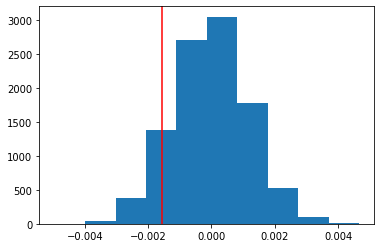

In [27]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

In [28]:
(p_diffs > obs_diff).mean()

0.9065


Since p = 0.9017 is significantly greater than the threshold for Type I error rates at 0.05, we fail to reject the null hypothesis that: $$p_{new} \leq p_{old}$$

$$or$$

$$p_{new} - p_{old} \leq 0$$

In [29]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest as ztest

#number of conversions for each page
convert_old = df2[df2['landing_page'] == 'old_page'].converted.sum()
convert_new = df2[df2['landing_page'] == 'new_page'].converted.sum()

#number of individuals who received each page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

c:\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [30]:
zstat, pval = ztest([convert_new, convert_old],
                 [n_new, n_old],
                 alternative='larger')

print(zstat, pval)

-1.3109241984234394 0.9050583127590245


The z-score calculated here is **-1.3109**. This means that the observed difference in conversion rates (-0.001578) between $p_{new}$ and $p_{old}$ is 1.3109 standard deviations away from the mean, which is 0. Let us examine the plot again.

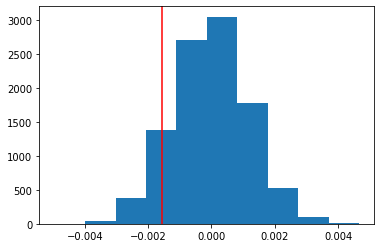

In [31]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

<a id='regression'></a>
### Part III - A regression approach

Logistic regression.

In [32]:
#create intercept, map to new df
df2a = df2.copy()
df2a['intercept'] = 1

#create dummy variables for landing_page, map to new df
ab_dummies = pd.get_dummies(df2a['landing_page'])
df2b = df2a.join(ab_dummies)
df2b.rename(columns = {'new_page' : 'ab_page'}, inplace=True)
df2b.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [33]:
#drop baseline variable, 'old_page'
df2b.drop('old_page', axis = 1, inplace = True)
df2b.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [34]:
import statsmodels.api as sm

rm = sm.Logit(df2b['converted'], df2b[['intercept', 'ab_page']])

In [35]:
rm.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Feb 2022   Pseudo R-squ.:               8.077e-06
Time:                        15:31:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""



Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [37]:
### Create the necessary dummy variables
country_dummies = pd.get_dummies(df_new['country'])

df_newa = df_new.join(country_dummies)
df_newa.head()

,country,timestamp,group,landing_page,converted,CA,UK,US
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0


In [38]:
#'US' as baseline country
df_newa['intercept'] = 1
rm_a = sm.Logit(df_newa['converted'], df_newa[['intercept', 'CA', 'UK']])
rm_a.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 Feb 2022   Pseudo R-squ.:               1.521e-05
Time:                        15:31:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [39]:
#exponentiate coefficients
CA = np.exp(-0.0408)
UK = 1/np.exp(0.0099)

UK, CA

(0.9901488436829571, 0.9600211149716509)

In [40]:
#get page dummies
page_dummies = pd.get_dummies(df_new['landing_page'])
page_dummies.head()

,new_page,old_page
user_id,,
834778,0,1
928468,1,0
822059,1,0
711597,0,1
710616,1,0


In [41]:
#form new df with all necessary columns
df_newb = df_newa.join(page_dummies)
df_newb.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept,new_page,old_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,1,0


In [42]:
df_newb = df_newb.rename(columns = {'new_page' : 'ab_page'} )
df_newb.drop('old_page', axis = 1, inplace = True)
df_newb.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept,ab_page
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,1


In [43]:
#create interaction column
df_newc = df_newb.copy()
df_newc['intercept'] = 1
df_newc['UK_ab_page'] = df_newb['UK'] * df_newb['ab_page']
df_newc['CA_ab_page'] = df_newb['CA'] * df_newb['ab_page']
df_newc.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept,ab_page,UK_ab_page,CA_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,1,1,0


In [44]:
#logistic regression model with US and old_page as baseline
rm_b = sm.Logit(df_newc['converted'], df_newc[['intercept', 'UK', 'CA', 'ab_page', 'UK_ab_page', 'CA_ab_page']])
rm_b.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 05 Feb 2022   Pseudo R-squ.:               3.482e-05
Time:                        15:31:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

In [45]:
#exponentiate coefficients

UK2 = np.exp(-.0046)
CA2 = np.exp(-0.0175
            )
ab_page = np.exp(-0.0236)
UK_ab_page = np.exp(-0.0236)
CA_ab_page = np.exp(-0.0469)

UK2, CA2, ab_page, UK_ab_page, CA_ab_page

(0.9954105637959723,
 0.9826522356650732,
 0.976676302155084,
 0.976676302155084,
 0.9541828111007262)